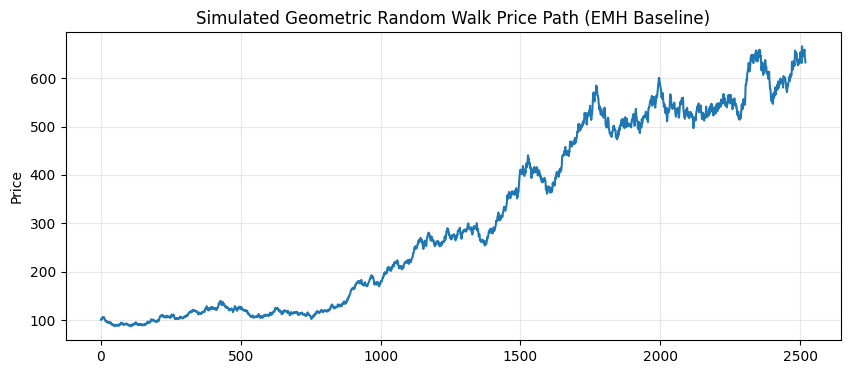

Fetching SPY EOD data...
EOD sample: 3527 observations


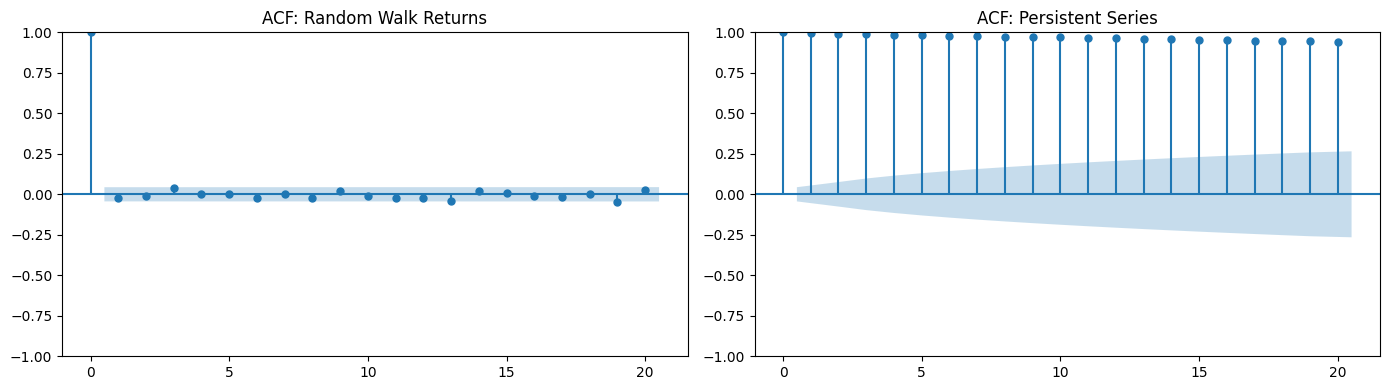

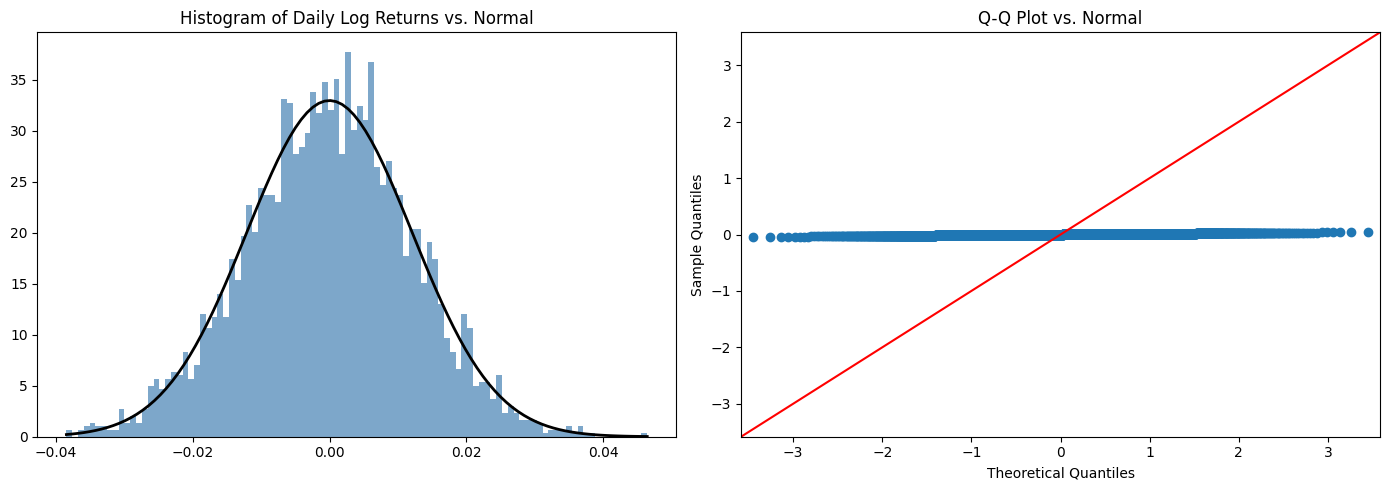

Skew: -0.040, Excess Kurtosis: 0.022
Extreme days (top/bottom 1%): 72 out of 3527
Worst daily return: -3.85%
Best daily return: 4.64%


In [5]:
"""
Python & AI for Algorithmic Trading - Review Questions (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

np.random.seed(42)

# =============================================================================
# Question 1
# Explain why simulated random walks are used as a baseline in efficiency tests.
# What does a random walk capture, and what does it ignore?
# =============================================================================

# Simulated random walks are used as a baseline because they represent the core null
# hypothesis of weak-form efficiency: returns are unpredictable (i.i.d.), and prices
# fully reflect past information.

# What it captures:
# - No serial correlation in returns → unpredictability.
# - Geometric compounding (prices = exp(cumulative log-returns)).
# - Linear drift in expectation (risk premium) and volatility scaling with √time.

# What it ignores:
# - Fat tails and leptokurtosis.
# - Volatility clustering.
# - Leverage effects, jumps, regime shifts, microstructure.

def simulate_gbm(n_steps=252*10, mu=0.08, sigma=0.20):
    dt = 1/252
    shocks = np.random.normal(0, sigma * np.sqrt(dt), n_steps)
    log_prices = np.cumsum(np.log(1 + mu*dt) + shocks)
    prices = 100 * np.exp(log_prices)
    return prices

prices = simulate_gbm()

plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title("Simulated Geometric Random Walk Price Path (EMH Baseline)")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Question 2
# Describe the role of end-of-day (EOD) prices in basic market-efficiency diagnostics.
# What are the main benefits and limitations of using daily data?
# =============================================================================

# Role: EOD adjusted closes provide clean, reliable series for computing daily returns,
# which form the basis for autocorrelation, normality, and predictability tests.

# Benefits:
# - Minimal microstructure noise (bid-ask bounce, HFT).
# - Dividend/split adjusted → accurate long-term returns.
# - Accessible and sufficient for retail-scale diagnostics.

# Limitations:
# - Misses intraday patterns (overnight vs. session returns).
# - Fewer observations → lower statistical power.
# - Asynchronous across global assets.

print("Fetching SPY EOD data...")
try:
    raw = yf.download('SPY', start='2010-01-01', auto_adjust=True, progress=False)
    df = raw['Close'].to_frame('close')
except Exception:
    n = 3528
    returns = np.random.normal(0.0004, 0.012, n)
    prices = 100 * np.cumprod(1 + returns)
    dates = pd.date_range('2010-01-04', periods=n, freq='B')
    df = pd.DataFrame({'close': prices}, index=dates)

df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
print(f"EOD sample: {len(df)} observations")

# =============================================================================
# Question 3
# Summarise how autocorrelation diagnostics help you detect predictability in returns.
# What does a near-zero autocorrelation at short lags imply?
# =============================================================================

# Autocorrelation diagnostics (ACF, Ljung-Box) measure linear dependence between
# returns and lagged returns. Significant non-zero values indicate predictability
# from past returns → violation of weak-form EMH.

# Near-zero short-lag autocorrelation implies returns are close to white noise →
# unpredictable from past returns → consistent with random walk / weak-form efficiency.

returns_rw = np.random.normal(0, 0.015, 2000)
returns_persistent = np.cumsum(np.random.normal(0, 0.015, 2000))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
tsaplots.plot_acf(returns_rw, lags=20, ax=ax1, title="ACF: Random Walk Returns")
tsaplots.plot_acf(returns_persistent, lags=20, ax=ax2, title="ACF: Persistent Series")
plt.tight_layout()
plt.show()

# =============================================================================
# Question 4
# Explain how histogram and quantile-quantile (Q-Q) plots assess normality.
# What stylised facts in equity returns do these plots typically reveal?
# =============================================================================

# Histogram: Compares empirical density to normal → reveals symmetry, peakedness, tails.
# Q-Q plot: Plots sample quantiles vs. theoretical normal → straight line = normal;
# deviations show fat tails (upward in extremes) or skewness.

# Typical stylised facts:
# - Leptokurtosis (fat tails): more extremes than normal.
# - Slight negative skew.
# - Higher peak around mean.

spy_ret = df['log_ret']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(spy_ret, bins=100, density=True, alpha=0.7, color='steelblue')
x = np.linspace(spy_ret.min(), spy_ret.max(), 100)
ax1.plot(x, stats.norm.pdf(x, spy_ret.mean(), spy_ret.std()), 'k', lw=2)
ax1.set_title("Histogram of Daily Log Returns vs. Normal")

sm.qqplot(spy_ret, line='45', ax=ax2)
ax2.set_title("Q-Q Plot vs. Normal")

plt.tight_layout()
plt.show()

print(f"Skew: {stats.skew(spy_ret):.3f}, Excess Kurtosis: {stats.kurtosis(spy_ret):.3f}")

# =============================================================================
# Question 5
# Describe the purpose of analysing extreme days in return data.
# Why are tail events especially relevant for trading strategies and risk limits?
# =============================================================================

# Purpose:
# - Quantify tail risk (VaR, ES).
# - Identify clustering or patterns in extremes.
# - Stress-test strategies during crises.

# Relevance:
# - Tails drive most PnL variability (fat-tailed distributions).
# - Many strategies fail in extremes (e.g., momentum crashes).
# - Risk limits must survive rare events; normality underestimates tail risk.

threshold = np.percentile(spy_ret, [1, 99])
extreme_days = spy_ret[(spy_ret < threshold[0]) | (spy_ret > threshold[1])]

print(f"Extreme days (top/bottom 1%): {len(extreme_days)} out of {len(spy_ret)}")
print(f"Worst daily return: {spy_ret.min():.2%}")
print(f"Best daily return: {spy_ret.max():.2%}")